# Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

<center>
<img 
     src="http://www2.famaf.unc.edu.ar/~efernandez/egeo/img/logos/famaf.jpg" 
     alt="Drawing" 
     style="width:30%;"
/>
</center>

# Universidad Nacional de Córdoba
---

### Importación de librerías

In [1]:
import warnings
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVR

from pandas.plotting import lag_plot

import pyarrow
import fastparquet

import statsmodels

### Lectura del dataset 

In [2]:
df = pd.read_parquet('../notebooks_tp2/sin_codificar.parquet')
df

,dni_titular_movimiento,fecha_cupon_movimiento,moneda_movimiento,producto_naranja_movimiento,tipo_producto_tarjeta_movimiento,anio_mes_cupon,sexo_descripcion,monto_ajustado,cargo_sector_desc_hist,edad_cliente,antig_cliente,comercio_cat,estado_civil_cat,region
0,0001686b52949b5461ffcbc766687e45031,2020-08-25,0,PL,0,202008,Hombre,5.52,Sector_Empleado_Comercio,61.0,92,0,Otros,REGION PAMPEANA
1,000220fa96ec5af89817894033f8099c547,2020-08-25,0,PL,0,202008,Mujer,15.68,Sector_Sin_Datos,29.0,2,0,Sin_datos,REGION CUYO
2,0002be202de47dfae9cc2304d91161be595,2020-08-25,0,PL,0,202008,Mujer,5.46,Sector_Sin_Datos,28.0,95,0,Soltero,REGION PAMPEANA
3,000e137d0af42e193be1ff670c00d4d1506,2020-08-25,0,PL,0,202008,Hombre,2.50,Sector_Empleado_Comercio,40.0,151,0,Soltero,REGION PAMPEANA
4,0009d010e4faf69552a814a33832b185877,2020-08-25,0,PL,0,202008,Mujer,2.10,Sector_Empleado_Comercio,36.0,87,0,Soltero,REGION PAMPEANA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124309,0001f61dd2845a7e653ebfdaf22dab3b373,2021-05-14,0,PC,3,202105,Mujer,20329.24,Sector_Empleado_Comercio,48.0,98,0,Casado,REGION PATAGONIA
124310,0001f61dd2845a7e653ebfdaf22dab3b373,2021-05-14,0,PC,3,202105,Mujer,20329.24,Sector_Empleado_Comercio,48.0,98,0,Casado,REGION PATAGONIA
124311,0006c15ca823454b68c189da1344d9d7317,2021-05-14,0,PC,3,202105,Hombre,13210.67,Sector_No_Operativo,66.0,105,0,Casado,REGION NORDESTE
124312,0000ab27a0ed815f947df8bcb834ff97975,2021-05-03,0,PC,3,202105,Hombre,121.73,Sector_Empleado_Comercio,74.0,140,0,Soltero,REGION NOROESTE


Ordenamos nuestro conjunto de datos en función a la variable anio_mes_cupon.

In [3]:
df = df.sort_values(by = ['anio_mes_cupon'], ascending = True)
df

,dni_titular_movimiento,fecha_cupon_movimiento,moneda_movimiento,producto_naranja_movimiento,tipo_producto_tarjeta_movimiento,anio_mes_cupon,sexo_descripcion,monto_ajustado,cargo_sector_desc_hist,edad_cliente,antig_cliente,comercio_cat,estado_civil_cat,region
105152,000821b0a8bdb0450e97298899adc5a3652,2020-07-30,3,PL,3,202007,Hombre,28.99,Sector_Empleado_Comercio,36.0,122,6,Soltero,REGION NOROESTE
101268,0003a7e1566088a9a9b1fc374c49ef4e389,2020-07-29,0,VI,22,202007,Hombre,1319.95,Sector_Sin_Datos,50.0,45,9,Casado,REGION PAMPEANA
101267,000802e16e0ea151e8c748d14042412c907,2020-07-23,0,VI,22,202007,Mujer,1304.35,Sector_Empleado_Comercio,52.0,241,9,Casado,REGION PATAGONIA
101266,0000df1c1ff76e859bdc85a831744d84018,2020-07-29,0,VI,22,202007,Mujer,2925.72,Sector_Sin_Datos,52.0,44,9,Casado,REGION PAMPEANA
101265,00076b06d9e78dbf994474315801d3a0296,2020-07-31,0,VI,22,202007,Mujer,2880.43,Sector_Empleado_Comercio,57.0,93,9,Casado,REGION PAMPEANA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6100,000a9fa6856d6d70da80b3320cbb7a58581,2021-05-25,0,PL,0,202105,Hombre,2660.35,Sector_Sin_Datos,33.0,5,0,Soltero,REGION NOROESTE
112579,000048290a3054197cc33ba82633d7c3628,2021-05-05,0,PC,3,202105,Hombre,17117.80,Sector_No_Operativo,80.0,91,0,Soltero,REGION PAMPEANA
124313,0000ab27a0ed815f947df8bcb834ff97975,2021-05-03,0,PC,3,202105,Hombre,12284.16,Sector_Empleado_Comercio,74.0,140,0,Soltero,REGION NOROESTE
11978,0007d3573a085abc49ede83321981a7d760,2021-05-25,1,PL,0,202106,Mujer,-9.00,Sector_Sin_Datos,50.0,181,0,Casado,REGION PAMPEANA


In [4]:
df['monto_ajustado'].describe().round(2)

count    114212.00
mean       1576.89
std        4119.05
min      -35117.69
25%          83.89
50%         266.39
75%        1261.19
max       63616.14
Name: monto_ajustado, dtype: float64

Distribución de nuestro target respecto a nuestros features

### ScatterPlot de Features y Target

In [5]:
df_sin_docu = df.copy()
df_sin_docu.drop(columns=['dni_titular_movimiento','monto_ajustado'], inplace=True)
df_sin_docu['monto_ajustado'] = df['monto_ajustado']

In [6]:
col_x = df_sin_docu.iloc[:,:-1].columns.values
col_x

array(['fecha_cupon_movimiento', 'moneda_movimiento',
       'producto_naranja_movimiento', 'tipo_producto_tarjeta_movimiento',
       'anio_mes_cupon', 'sexo_descripcion', 'cargo_sector_desc_hist',
       'edad_cliente', 'antig_cliente', 'comercio_cat',
       'estado_civil_cat', 'region'], dtype=object)

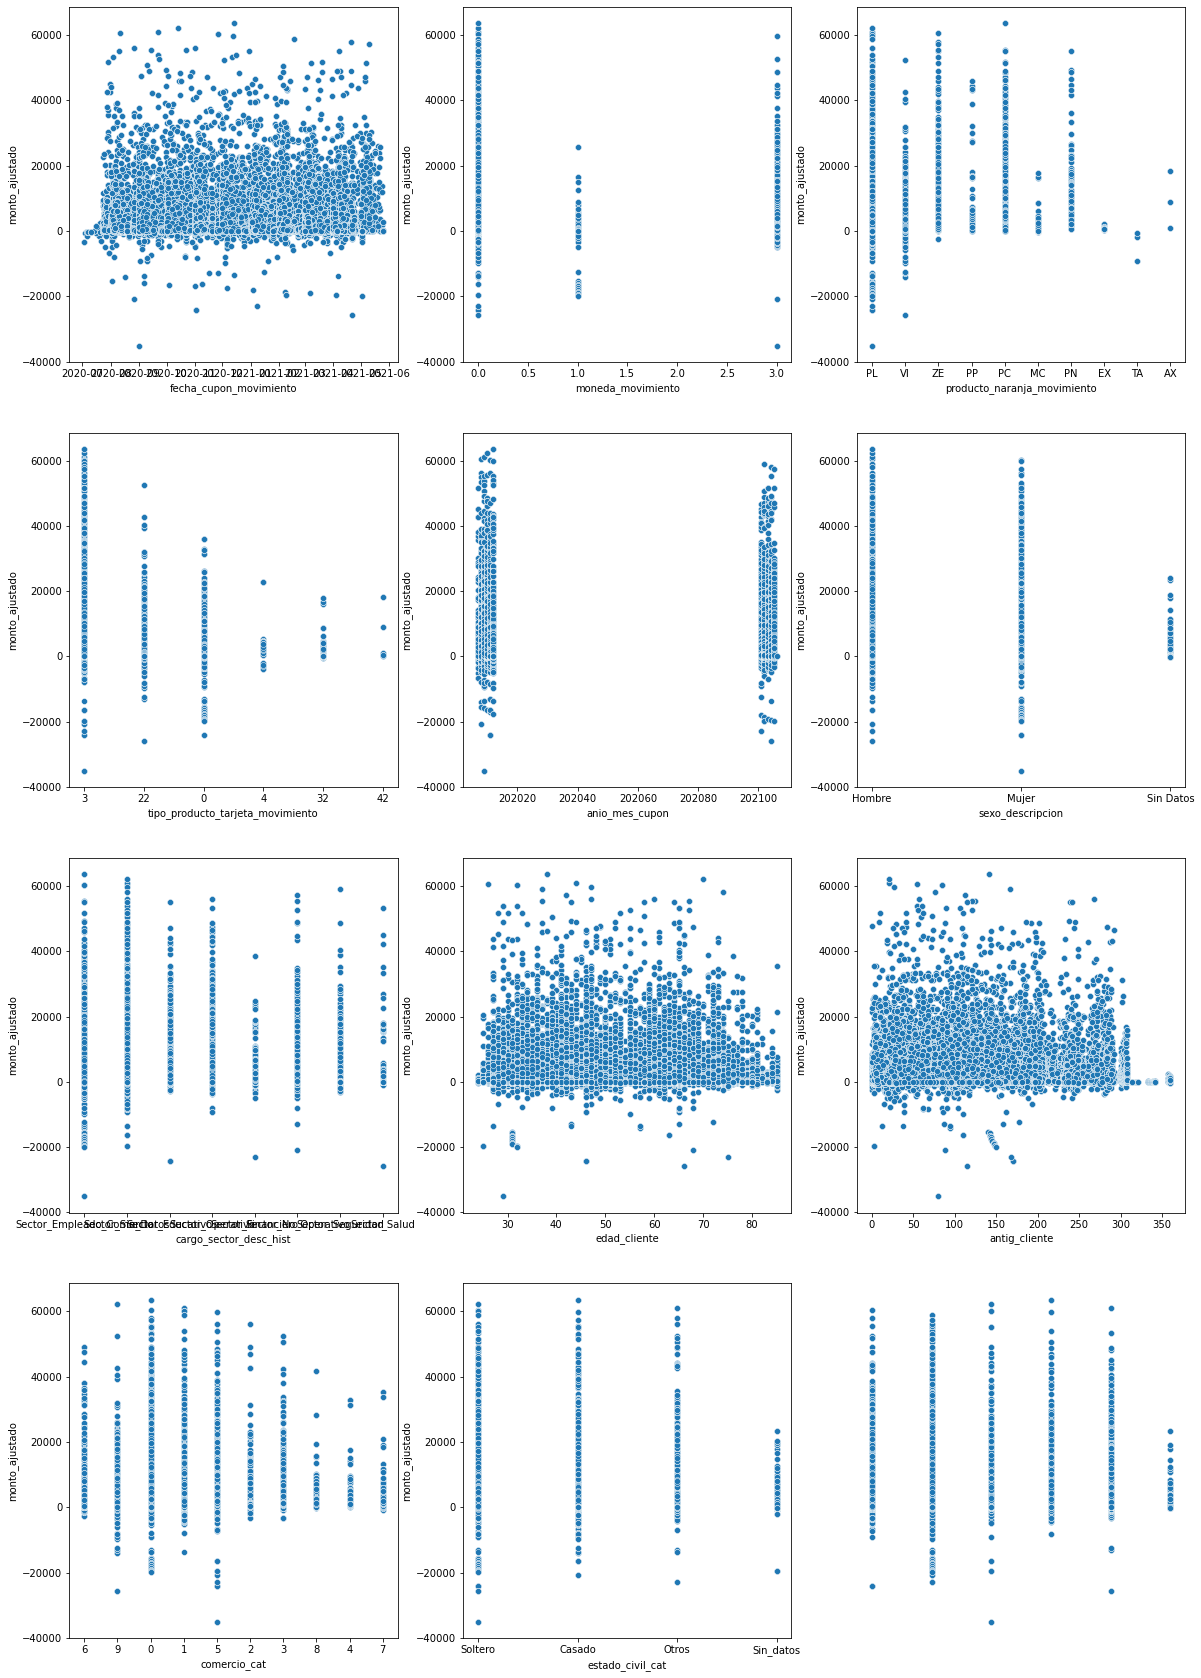

In [7]:
n_cols = 3
n_rows = math.ceil(len(col_x)/3)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 30))
count = 0
for i in col_x:    
    # Calculamos filas y columnas
    row = math.floor(count / n_cols)
    col = count % n_cols
    # Configuramos visualización
    ax = axs[row, col]
    # Visualizamos la distribución de variable
    sns.scatterplot(data=df_sin_docu, x=i, y='monto_ajustado', ax=ax)
    count =count +1

axs[n_rows-1,n_cols-1].axis('off')
plt.show()

### Agrupación por Fecha y por Mes

In [8]:
# df.loc[:,'fecha_cupon_movimiento'] = pd.to_datetime(df['fecha_cupon_movimiento']).astype(int)/10**11  >> Me daba error "Juani"
df.loc[:,'fecha_cupon_movimiento'] = df['fecha_cupon_movimiento'].values.astype(float)/10**11

In [9]:
df.loc[:, 'moneda_movimiento'] = df['moneda_movimiento'].astype(str)

In [10]:
df.dtypes

dni_titular_movimiento               object
fecha_cupon_movimiento              float64
moneda_movimiento                    object
producto_naranja_movimiento          object
tipo_producto_tarjeta_movimiento     object
anio_mes_cupon                        int64
sexo_descripcion                     object
monto_ajustado                      float64
cargo_sector_desc_hist               object
edad_cliente                        float64
antig_cliente                         int64
comercio_cat                         object
estado_civil_cat                     object
region                               object
dtype: object

In [11]:
ordinal_ft = 'dni_titular_movimiento'
target = 'monto_ajustado'

# Features numericas
num_features = ['anio_mes_cupon', 'edad_cliente', 'antig_cliente', 'fecha_cupon_movimiento']

# Features categoricas de la transaccion
trans_ft = ['producto_naranja_movimiento', 'tipo_producto_tarjeta_movimiento', 'moneda_movimiento', 'comercio_cat']

# Features categoricas del cliente
client_ft = ['sexo_descripcion', 'cargo_sector_desc_hist', 'estado_civil_cat', 'region']

In [12]:
df = df.sort_values(by = ['fecha_cupon_movimiento'], ascending = True)

cat_transformer = OneHotEncoder(handle_unknown='ignore')

encoder = ColumnTransformer(
    transformers=[
        ('dni', 'drop', [ordinal_ft]),
        ('num', 'passthrough', num_features),
        ('trans', cat_transformer, trans_ft),
        ('client', cat_transformer, client_ft),
        ('target', 'passthrough', [target])])
df_enc = encoder.fit_transform(df)
cols = encoder.get_feature_names()

df_enc.shape

(114212, 55)

In [13]:
df_enc = pd.DataFrame.sparse.from_spmatrix(df_enc, columns=[cols]).sparse.to_dense()

In [14]:
# Agregar feature ordinal al principio del dataframe
cols_o = np.hstack([[ordinal_ft],cols])
df_stack = np.hstack([df[[ordinal_ft]],df_enc])
df_encode = pd.DataFrame(df_stack , columns=cols_o)

# Funciones de agregacion para cada columna
aggr = {} 
aggr.update(dict.fromkeys([x for x in cols if 'client' in x], 'max'))
aggr.update(dict.fromkeys([x for x in cols if 'trans' in x], 'sum'))
aggr.update({target:'sum'})

### Agrupación x Mes

In [15]:
# Agrupamiento por mes
group = ['dni_titular_movimiento', 'anio_mes_cupon']

df_mes = df_encode.groupby(group).agg(aggr).reset_index() # edad y antiguedad

### Agrupación x Fecha

In [16]:
# Agrupamiento por fecha
group = ['dni_titular_movimiento', 'fecha_cupon_movimiento']

df_fecha = df_encode.groupby(group).agg(aggr).reset_index() # edad y antiguedad

In [17]:
df_encode.values

array([['00017c577769060500211670502411b5913', 202007.0, 62.0, ..., 0.0,
        0.0, -3445.56],
       ['00017c577769060500211670502411b5913', 202007.0, 62.0, ..., 0.0,
        0.0, -3445.56],
       ['0000c20705a45563f2ec6a53088c2a30090', 202007.0, 80.0, ..., 0.0,
        0.0, -707.0],
       ...,
       ['00035974dec6a645cba119b126c40ed4652', 202105.0, 38.0, ..., 0.0,
        0.0, -4.69],
       ['0001b49c252907291ca16195773ef104079', 202105.0, 49.0, ..., 0.0,
        0.0, 82.64],
       ['0007d3573a085abc49ede83321981a7d760', 202106.0, 50.0, ..., 0.0,
        0.0, -9.0]], dtype=object)

In [18]:
df_mes.describe()

,anio_mes_cupon,edad_cliente,antig_cliente,client__x0_Hombre,client__x0_Mujer,client__x0_Sin Datos,client__x1_Sector_Educativo,client__x1_Sector_Empleado_Comercio,client__x1_Sector_Financiero,client__x1_Sector_No_Operativo,...,trans__x3_1,trans__x3_2,trans__x3_3,trans__x3_4,trans__x3_5,trans__x3_6,trans__x3_7,trans__x3_8,trans__x3_9,monto_ajustado
count,7443.000000,7443.000000,7443.000000,7443.000000,7443.000000,7443.000000,7443.000000,7443.000000,7443.000000,7443.000000,...,7443.000000,7443.000000,7443.000000,7443.000000,7443.000000,7443.000000,7443.000000,7443.000000,7443.000000,7443.000000
mean,202052.953245,49.149536,107.739755,0.460836,0.533118,0.006046,0.058444,0.193202,0.011017,0.084106,...,3.602177,0.547226,0.324735,0.022975,1.703345,0.235658,0.046621,0.099019,2.288728,24197.194262
std,46.437423,14.954749,76.457279,0.498497,0.498935,0.077526,0.234597,0.394836,0.104389,0.277565,...,6.045837,1.874314,1.924541,0.336978,3.562076,1.683610,0.628194,0.929670,5.939887,31009.223800
min,202007.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-27864.760000
25%,202010.000000,36.000000,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2029.270000
50%,202012.000000,47.000000,93.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12700.540000
75%,202103.000000,61.000000,156.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,35199.635000
max,202106.000000,85.000000,360.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,72.000000,36.000000,34.000000,14.000000,112.000000,81.000000,28.000000,25.000000,126.000000,300740.420000


In [19]:
df_fecha.describe()

,fecha_cupon_movimiento,edad_cliente,antig_cliente,client__x0_Hombre,client__x0_Mujer,client__x0_Sin Datos,client__x1_Sector_Educativo,client__x1_Sector_Empleado_Comercio,client__x1_Sector_Financiero,client__x1_Sector_No_Operativo,...,trans__x3_1,trans__x3_2,trans__x3_3,trans__x3_4,trans__x3_5,trans__x3_6,trans__x3_7,trans__x3_8,trans__x3_9,monto_ajustado
count,3.198100e+04,31981.000000,31981.000000,31981.000000,31981.000000,31981.000000,31981.000000,31981.000000,31981.000000,31981.000000,...,31981.000000,31981.000000,31981.000000,31981.000000,31981.000000,31981.000000,31981.000000,31981.000000,31981.000000,31981.000000
mean,1.608104e+07,49.380664,112.753604,0.466527,0.527688,0.005785,0.073606,0.207592,0.016791,0.079766,...,0.838342,0.127357,0.075576,0.005347,0.396423,0.054845,0.010850,0.023045,0.532660,5631.459832
std,6.941602e+04,14.749501,78.827104,0.498886,0.499241,0.075838,0.261133,0.405589,0.128490,0.270935,...,1.886742,0.621691,0.512762,0.115156,1.036756,0.415228,0.176587,0.255766,1.164827,11325.153935
min,1.593734e+07,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-39645.540000
25%,1.602115e+07,37.000000,46.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,566.060000
50%,1.608509e+07,47.000000,98.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1670.840000
75%,1.614211e+07,61.000000,170.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5502.680000
max,1.621901e+07,85.000000,360.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,35.000000,16.000000,14.000000,5.000000,18.000000,16.000000,10.000000,10.000000,14.000000,180632.220000


## 3. Regresión

Una vez finalizada la etapa de preprocesamiento, se propone implementar diferentes modelos 
de predicción para el `monto_compra_movimiento`, utilizando la librería Scikit-Learn:

* LinearSVR ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html#sklearn.svm.LinearSVR))
* SGDRegressor ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor))
* KNeighborsRegressor ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor))
* GaussianProcessRegressor ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor))
* VotingRegressor ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html#sklearn.ensemble.VotingRegressor))

Y de la libreria XGBoost
* XGBRegressor ([Doc](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor))

De estos tipos de modelos, cuál creen que es el más adecuado para nuestro caso de aplicación?

Utilizar el método Grid Search, o de búsqueda exahustiva, con cross-validation para profundizar en la búsqueda y selección de hiperparámetros.

Calcular métricas sobre el conjunto de entrenamiento y de evaluación para los mejores parámetros obtenidos:
* MSE 
* MAE 
* RMSE

Comparar las métricas obtenidas en cada modelo y obtener conclusiones.

> Una vez encontrado el mejor modelo se validara usando el conjunto de evaluacion dado por el mentor

### Función de modelo (Default)

In [ ]:
def run_model(data, ordinal_ft, target, model_, num_transformer = StandardScaler() ):
    # Separar features de target
    X = data.drop([ordinal_ft, target], axis=1)
    y = data[target]

    # Separar en train y validacion
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

    # Escalar
    num_transformer = num_transformer
    cat_transformer = 'passthrough'

    num_features = [g for g in X.columns if 'client' not in g]
    cat_features = [g for g in X.columns if 'client' in g]

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_features),
            ('cat', cat_transformer, cat_features)])

    # Modelo
    model = Pipeline([
      ('preprocessor', preprocessor),
      ('feature_selection', SelectFromModel(model_)),
      ('regressor', model_)
    ])

    model.fit(X_train, y_train)

    # Predict
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_val)
    
    return X_train, X_val, y_train, y_val, y_train_pred, y_valid_pred

### Linear SVR - Default

Realizamos una copia de nuestro dataset codificado para no tocar el mismo.

In [28]:
dff = df_encode.copy()

Instanciamos nuestro modelo de Linear SVR por defecto

In [35]:
model = LinearSVR(random_state=0)

Corremos nuestra función **run_model** para nuestro conjunto de datos

In [29]:
X_train, X_val, y_train, y_val, y_train_pred, y_valid_pred = run_model(dff, ordinal_ft, target, model)

C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [30]:
# evaluate MSE:
train_error = mean_squared_error(y_train, y_train_pred)
val_error = mean_squared_error(y_val, y_valid_pred)
print(f'Train error {train_error.round(3)}, Valid error {val_error.round(3)}')  

Train error 15154718.865, Valid error 12569048.264


In [31]:
# evaluate RMSE:
train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_error = np.sqrt(mean_squared_error(y_val, y_valid_pred))
print(f'Train error RMSE {train_error.round(3)}, Valid error RMSE {val_error.round(3)}')  

Train error RMSE 3892.906, Valid error RMSE 3545.285


In [32]:
# evaluate MAE:
train_error = mean_absolute_error(y_train, y_train_pred)
val_error = mean_absolute_error(y_val, y_valid_pred)
print(f'Train error MAE {train_error.round(3)}, Valid error MAE {val_error.round(3)}')  

Train error MAE 1292.816, Valid error MAE 1184.446


Visualizamos nuestra variable target (real y predicción)

In [36]:
y_val.values

array([2005.94, 10252.6, 5310.55, ..., -4.69, 82.64, -9.0], dtype=object)

In [37]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,34264.00
mean,1507.19
std,3965.95
min,-25775.00
25%,87.00
50%,254.00
75%,1081.00
max,58939.00


In [38]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,34264.00
mean,765.86
std,1247.54
min,-477.20
25%,81.34
50%,333.71
75%,812.15
max,7882.65


### Linear SVR - Grid Search

In [40]:
svr = LinearSVR(random_state=0)

param_grid = {
    'epsilon': [0.1, 0.01, 0.0001,0.001],
    'tol': [1e-3, 1e-4, 1e-5, 1e-6],
    'C': [1, 2, 0.01, 0.001],
    'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']
}

cv_svr = GridSearchCV(svr, param_grid, scoring='neg_mean_squared_error',cv=5)
#cv_svr.fit(X_train_r, y_train_r.ravel())

In [41]:
X_train, X_val, y_train, y_val, y_train_pred, y_valid_pred = run_model(dff, ordinal_ft, target, cv_svr)

C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


KeyboardInterrupt: 

In [ ]:
cv_svr.best_params_

In [ ]:
cv_svr.best_estimator_

In [ ]:
# Predict
y_train_pred_svr = cv_svr.best_estimator_.predict(X_train_r)
y_valid_pred_svr = cv_svr.best_estimator_.predict(X_val_r)

In [ ]:
# evaluate MSE:
train_error_svr = mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_svr.reshape(-1,1)))
val_error_svr = mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_svr.reshape(-1,1)))
print(f'Train error MSE {train_error_svr.round(3)}, Valid error MSE {val_error_svr.round(3)}') 

In [ ]:
# evaluate MAE:
train_error_svr = mean_absolute_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_svr.reshape(-1,1)))
val_error_svr = mean_absolute_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_svr.reshape(-1,1)))
print(f'Train error MAE {train_error_svr.round(3)}, Valid error MAE {val_error_svr.round(3)}') 

In [ ]:
# evaluate RMSE:
train_error_svr = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_svr.reshape(-1,1))))
val_error_svr = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_svr.reshape(-1,1))))
print(f'Train error RMSE {train_error_svr.round(3)}, Valid error RMSE {val_error_svr.round(3)}') 

In [ ]:
pd.DataFrame(y_scaler.inverse_transform(y_val_r), columns=['val_real']).describe().round(2)

In [ ]:
pd.DataFrame(y_scaler.inverse_transform(y_valid_pred_svr.reshape(-1,1)), columns=['val_pred']).describe().round(2)

### SGDRegressor - Default

In [ ]:
from sklearn.linear_model import SGDRegressor

Utilizamos las variables X_train_r, X_val_r, y_train_r, y_val_r debido a que en este modelo utilizamos el mismo escalado que SVM-R. 

In [ ]:
# Fit
sgd = SGDRegressor(random_state=0, shuffle=False)
sgd.fit(X_train_r, y_train_r.ravel())

In [ ]:
# Predict
y_train_pred_sgd = sgd.predict(X_train_r)
y_valid_pred_sgd = sgd.predict(X_val_r)

In [ ]:
# evaluate:
train_error_sgd = mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_sgd.reshape(-1,1)))
val_error_sgd = mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_sgd.reshape(-1,1)))
print(f'Train error {train_error_sgd.round(3)}, Valid error {val_error_sgd.round(3)}')  

In [ ]:
# evaluate MAE:
train_error_sgd = mean_absolute_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_sgd.reshape(-1,1)))
val_error_sgd = mean_absolute_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_sgd.reshape(-1,1)))
print(f'Train error MAE {train_error_sgd.round(3)}, Valid error MAE {val_error_sgd.round(3)}') 

In [ ]:
# evaluate RMSE:
train_error_sgd = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_sgd.reshape(-1,1))))
val_error_sgd = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_sgd.reshape(-1,1))))
print(f'Train error RMSE {train_error_sgd.round(3)}, Valid error RMSE {val_error_sgd.round(3)}') 

Visualizamos nuestra variable target (real y predicción)

In [ ]:
pd.DataFrame(y_scaler.inverse_transform(y_val_r), columns=['val_real']).describe().round(2)

In [ ]:
pd.DataFrame(y_scaler.inverse_transform(y_valid_pred_sgd.reshape(-1,1)), columns=['val_pred']).describe().round(2)

### SGDRegressor- Grid Search

In [ ]:
y_train_r

In [ ]:
param_grid = {
    'loss': ['squared_loss','huber','epsilon_insensitive','squared_epsilon_insensitive'],
    'penalty': ['l2','l1'],
    'alpha': [0.001, 0.01, 0.1, 1],
    'epsilon': [0.1, 0.01],
    'tol': [1e-3, 1e-4],
    'learning_rate': ['optimal', 'constant', 'adaptive','invscaling']
    #'max_iter': [1000, 2000, 5000]
}

cv_sgd = GridSearchCV(sgd, param_grid, scoring='neg_mean_squared_error',cv=5)
cv_sgd.fit(X_train_r, y_train_r.ravel())

In [ ]:
cv_sgd.best_params_

In [ ]:
cv_sgd.best_estimator_

In [ ]:
# Predict
y_train_pred_sgd = cv_sgd.best_estimator_.predict(X_train_r)
y_valid_pred_sgd = cv_sgd.best_estimator_.predict(X_val_r)

In [ ]:
# evaluate MSE:
train_error_sgd = mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_sgd.reshape(-1,1)))
val_error_sgd = mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_sgd.reshape(-1,1)))
print(f'Train error {train_error_sgd.round(3)}, Valid error {val_error_sgd.round(3)}')   

In [ ]:
# evaluate MAE:
train_error_sgd = mean_absolute_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_sgd.reshape(-1,1)))
val_error_sgd = mean_absolute_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_sgd.reshape(-1,1)))
print(f'Train error MAE {train_error_sgd.round(3)}, Valid error MAE {val_error_sgd.round(3)}') 

In [ ]:
# evaluate RMSE:
train_error_sgd = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_sgd.reshape(-1,1))))
val_error_sgd = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_sgd.reshape(-1,1))))
print(f'Train error RMSE {train_error_sgd.round(3)}, Valid error RMSE {val_error_sgd.round(3)}') 

Visualizamos nuestra variable target (real y predicción)

In [ ]:
pd.DataFrame(y_scaler.inverse_transform(y_val_r), columns=['val_real']).describe().round(2)

In [ ]:
pd.DataFrame(y_scaler.inverse_transform(y_valid_pred_sgd.reshape(-1,1)), columns=['val_pred']).describe().round(2)

### KNeighborsRegressor - Default

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
neigh = KNeighborsRegressor()
neigh.fit(X_train_r, y_train_r.ravel())

In [ ]:
# Predict
y_train_pred_neigh = neigh.predict(X_train_r)
y_valid_pred_neigh = neigh.predict(X_val_r)

In [ ]:
# evaluate MSE:
train_error_neigh = mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_neigh.reshape(-1,1)))
val_error_neigh = mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_neigh.reshape(-1,1)))
print(f'Train error {train_error_neigh.round(3)}, Valid error {val_error_neigh.round(3)}')   

In [ ]:
# evaluate MAE:
train_error_neigh = mean_absolute_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_neigh.reshape(-1,1)))
val_error_neigh = mean_absolute_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_neigh.reshape(-1,1)))
print(f'Train error {train_error_neigh.round(3)}, Valid error {val_error_neigh.round(3)}')   

In [ ]:
# evaluate RMSE:
train_error_neigh = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_neigh.reshape(-1,1))))
val_error_neigh = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_neigh.reshape(-1,1))))
print(f'Train error {train_error_neigh.round(3)}, Valid error {val_error_neigh.round(3)}') 

In [ ]:
pd.DataFrame(y_scaler.inverse_transform(y_val_r), columns=['val_real']).describe().round(2)

In [ ]:
pd.DataFrame(y_scaler.inverse_transform(y_valid_pred_neigh.reshape(-1,1)), columns=['val_pred']).describe().round(2)

### KNeighborsRegressor - Grid Search

In [ ]:
param_grid = {
    'n_neighbors': [2, 3, 4, 5],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto','ball_tree','kd_tree','brute'],
    'p': [1,2]
}
cv_neigh = GridSearchCV(neigh, param_grid, scoring='neg_mean_squared_error',cv=5)
cv_neigh.fit(X_train_r, y_train_r.ravel())

In [ ]:
cv_neigh.best_params_

In [ ]:
cv_neigh.best_estimator_

In [ ]:
# Predict
y_train_pred_neigh = cv_neigh.best_estimator_.predict(X_train_r)
y_valid_pred_neigh = cv_neigh.best_estimator_.predict(X_val_r)

In [ ]:
# evaluate MSE:
train_error_neigh = mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_neigh.reshape(-1,1)))
val_error_neigh = mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_neigh.reshape(-1,1)))
print(f'Train error {train_error_neigh.round(3)}, Valid error {val_error_neigh.round(3)}')   

In [ ]:
# evaluate MAE:
train_error_neigh = mean_absolute_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_neigh.reshape(-1,1)))
val_error_neigh = mean_absolute_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_neigh.reshape(-1,1)))
print(f'Train error {train_error_neigh.round(3)}, Valid error {val_error_neigh.round(3)}')   

In [ ]:
# evaluate RMSE:
train_error_neigh = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_neigh.reshape(-1,1))))
val_error_neigh = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_neigh.reshape(-1,1))))
print(f'Train error {train_error_neigh.round(3)}, Valid error {val_error_neigh.round(3)}') 

Visualizamos nuestra variable target (real y predicción)

In [ ]:
pd.DataFrame(y_scaler.inverse_transform(y_val_r), columns=['val_real']).describe().round(2)

In [ ]:
pd.DataFrame(y_scaler.inverse_transform(y_valid_pred_neigh.reshape(-1,1)), columns=['val_pred']).describe().round(2)

### GaussianProcessRegressor - Default

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor

In [ ]:
# Toma por parametro un kernel por defecto que probablemente habria que optimizar 
gpr = GaussianProcessRegressor(random_state=0)
gpr.fit(X_train_r, y_train_r.ravel())

In [ ]:
# Predict
y_train_pred_gpr = gpr.predict(X_train_r)
y_valid_pred_gpr = gpr.predict(X_val_r)

In [ ]:
# evaluate MSE:
train_error_gpr  = mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_gpr.reshape(-1,1)))
val_error_gpr  = mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_gpr.reshape(-1,1)) )
print(f'Train error {train_error_gpr .round(3)}, Valid error {val_error_gpr .round(3)}')  

In [ ]:
# evaluate MAE:
train_error_gpr  = mean_absolute_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_gpr.reshape(-1,1)) )
val_error_gpr  = mean_absolute_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_gpr.reshape(-1,1)) )
print(f'Train error {train_error_gpr .round(3)}, Valid error {val_error_gpr .round(3)}')  

In [ ]:
# evaluate RMSE:
train_error_gpr = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_gpr.reshape(-1,1))))
val_error_gpr = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_gpr.reshape(-1,1))))
print(f'Train error RMSE {train_error_gpr.round(3)}, Valid error RMSE {val_error_gpr.round(3)}') 

In [ ]:
pd.DataFrame(y_scaler.inverse_transform(y_val_r), columns=['val_real']).describe().round(2)

In [ ]:
pd.DataFrame(y_scaler.inverse_transform(y_valid_pred_gpr.reshape(-1,1)), columns=['val_pred']).describe().round()

### GaussianProcessRegressor - Grid Search 

In [ ]:
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, RationalQuadratic, ExpSineSquared

In [ ]:
ker_rbf = ConstantKernel(1.0, constant_value_bounds="fixed") * RBF(1.0, length_scale_bounds="fixed")
ker_rq = ConstantKernel(1.0, constant_value_bounds="fixed") * RationalQuadratic(alpha=0.1, length_scale=1)
ker_expsine = ConstantKernel(1.0, constant_value_bounds="fixed") * ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1))

kernel_list = [ker_rbf, ker_rq, ker_expsine]

param_grid = {"kernel": kernel_list,
              "alpha": [1e1]}
              
            
    
    #'max_iter': [1000, 2000, 5000]


cv_gpr = GridSearchCV(gpr, param_grid, scoring='neg_mean_squared_error',cv=5)
cv_gpr.fit(X_train_r, y_train_r.ravel())

In [ ]:
cv_gpr.best_params_

In [ ]:
cv_gpr.best_estimator_

In [ ]:
# Predict
y_train_pred_gpr = cv_gpr.best_estimator_.predict(X_train_r)
y_valid_pred_gpr = cv_gpr.best_estimator_.predict(X_val_r)

In [ ]:
# evaluate MSE:
train_error_gpr = mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_gpr.reshape(-1,1)))
val_error_gpr = mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_gpr.reshape(-1,1)))
print(f'Train error {train_error_gpr.round(3)}, Valid error {val_error_gpr.round(3)}')  

In [ ]:
# evaluate MAE:
train_error_gpr = mean_absolute_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_gpr.reshape(-1,1)))
val_error_gpr = mean_absolute_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_gpr.reshape(-1,1)))
print(f'Train error MAE {train_error_gpr.round(3)}, Valid error MAE {val_error_gpr.round(3)}') 

In [ ]:
# evaluate RMSE:
train_error_gpr = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_gpr.reshape(-1,1))))
val_error_gpr = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_gpr.reshape(-1,1))))
print(f'Train error RMSE {train_error_gpr.round(3)}, Valid error RMSE {val_error_gpr.round(3)}') 

Visualizamos nuestra variable target (real y predicción)

In [ ]:
pd.DataFrame(y_scaler.inverse_transform(y_val_r), columns=['val_real']).describe().round(2)

In [ ]:
pd.DataFrame(y_scaler.inverse_transform(y_valid_pred_gpr.reshape(-1,1)), columns=['val_pred']).describe().round(2)

### VotingRegressor

In [ ]:
from sklearn.ensemble import VotingRegressor

In [ ]:
#('gpr', cv_gpr.best_estimator_)
vr = VotingRegressor([('svr', cv_svr.best_estimator_), ('sgd', cv_sgd.best_estimator_), ('neigh', cv_neigh.best_estimator_),('gpr', cv_gpr.best_estimator_)])
vr.fit(X_train_r, y_train_r.ravel())

In [ ]:
# Predict
y_train_pred_vr = vr.predict(X_train_r)
y_valid_pred_vr = vr.predict(X_val_r)

In [ ]:
# evaluate MSE:
train_error_vr = mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_vr.reshape(-1,1)))
val_error_vr = mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_vr.reshape(-1,1)))
print(f'Train error {train_error_vr.round(3)}, Valid error {val_error_vr.round(3)}')

In [ ]:
# evaluate MAE:
train_error_vr = mean_absolute_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_vr.reshape(-1,1)))
val_error_vr = mean_absolute_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_vr.reshape(-1,1)))
print(f'Train error MAE {train_error_vr.round(3)}, Valid error MAE {val_error_vr.round(3)}') 

In [ ]:
# evaluate RMSE:
train_error_vr = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_vr.reshape(-1,1))))
val_error_vr = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_vr.reshape(-1,1))))
print(f'Train error RMSE {train_error_vr.round(3)}, Valid error RMSE {val_error_vr.round(3)}') 

In [ ]:
pd.DataFrame(y_scaler.inverse_transform(y_val_r), columns=['val_real']).describe().round(2)

In [ ]:
pd.DataFrame(y_scaler.inverse_transform(y_valid_pred_vr.reshape(-1,1)), columns=['val_pred']).describe().round(2)

### XGBRegressor - Default

In [ ]:
from xgboost import XGBRegressor

In [ ]:
# Toma por parametro un kernel por defecto que probablemente habria que optimizar 
xgb = XGBRegressor(random_state=0)
xgb.fit(X_train_r, y_train_r.ravel())

In [ ]:
# Predict
y_train_pred_xgb = xgb.predict(X_train_r)
y_valid_pred_xgb = xgb.predict(X_val_r)

In [ ]:
# evaluate MSE:
train_error_xgb  = mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_xgb.reshape(-1,1)))
val_error_xgb  = mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_xgb.reshape(-1,1)))
print(f'Train error {train_error_xgb.round(3)}, Valid error {val_error_xgb.round(3)}')  

In [ ]:
# evaluate MAE:
train_error_xgb = mean_absolute_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_xgb.reshape(-1,1)))
val_error_xgb = mean_absolute_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_xgb.reshape(-1,1)))
print(f'Train error MAE {train_error_xgb.round(3)}, Valid error MAE {val_error_xgb.round(3)}') 

In [ ]:
# evaluate RMSE:
train_error_xgb = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_xgb.reshape(-1,1))))
val_error_xgb = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_xgb.reshape(-1,1))))
print(f'Train error RMSE {train_error_xgb.round(3)}, Valid error RMSE {val_error_xgb.round(3)}') 

In [ ]:
pd.DataFrame(y_scaler.inverse_transform(y_val_r), columns=['val_real']).describe().round(2)

In [ ]:
pd.DataFrame(y_scaler.inverse_transform(y_valid_pred_xgb.reshape(-1,1)), columns=['val_pred']).describe().round(2)

### XGBRegressor - Grid Search

In [ ]:
param_grid = {'n_estimators': [8,10,15,20],
              'reg_alpha': [5, 10, 15],
              'max_depth': [20, 25, 30, 35],
              'booster' : ['gbtree', 'gblinear','dart']
    
    #'max_iter': [1000, 2000, 5000]
}

cv_xgb = GridSearchCV(xgb, param_grid, scoring='neg_mean_squared_error',cv=5)
cv_xgb.fit(X_train_r, y_train_r.ravel())

In [ ]:
cv_xgb.best_params_

In [ ]:
cv_xgb.best_estimator_

In [ ]:
# Predict
y_train_pred_xgb = cv_xgb.best_estimator_.predict(X_train_r)
y_valid_pred_xgb = cv_xgb.best_estimator_.predict(X_val_r)

In [ ]:
# evaluate MSE:
train_error_xgb  = mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_xgb.reshape(-1,1)))
val_error_xgb  = mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_xgb.reshape(-1,1)))
print(f'Train error {train_error_xgb.round(3)}, Valid error {val_error_xgb.round(3)}')  

In [ ]:
# evaluate MAE:
train_error_xgb = mean_absolute_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_xgb.reshape(-1,1)))
val_error_xgb = mean_absolute_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_xgb.reshape(-1,1)))
print(f'Train error MAE {train_error_xgb.round(3)}, Valid error MAE {val_error_xgb.round(3)}') 

In [ ]:
# evaluate RMSE:
train_error_xgb = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_xgb.reshape(-1,1))))
val_error_xgb = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_xgb.reshape(-1,1))))
print(f'Train error RMSE {train_error_xgb.round(3)}, Valid error RMSE {val_error_xgb.round(3)}') 

Visualizamos nuestra variable target (real y predicción)

In [ ]:
pd.DataFrame(y_scaler.inverse_transform(y_val_r), columns=['val_real']).describe().round(2)

In [ ]:
pd.DataFrame(y_scaler.inverse_transform(y_valid_pred_xgb.reshape(-1,1)), columns=['val_pred']).describe().round(2)

## 4. Clasificación
Una vez finalizada la etapa de preprocesamiento, se propone implementar diferentes modelos 
de predicción para la variable que indica si el consumo sera mas alto, o menor en el mes siguiente, utilizando la librería Scikit-Learn:

* RandomForestClassifier ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html))

Y de la libreria XGBoost
* XGBClassifier ([Doc](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier))

Comparar 
* precision
* recall  
* f1-score
* Accuracy

Comparar las métricas obtenidas en cada modelo y obtener conclusiones.

> Una vez encontrado el mejor modelo se validara usando el conjunto de evaluacion dado por el mentor

In [ ]:
# división train y test
X_train_c, X_val_c, y_train_c, y_val_c = train_test_split(X_c, y_c, test_size=0.3, random_state=0, shuffle=False)

In [ ]:
X_train_c.shape

In [ ]:
y_train_c.shape

In [ ]:
X_val_c.shape

In [ ]:
y_val_c.shape

### RandomForestClassifier - Grid Search

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

In [ ]:
# escalado de feauteres y target
#x_scaler = MinMaxScaler() #MaxAbsScaler()
#X_train_c = x_scaler.fit_transform(X_train_c)
#X_val_c = x_scaler.transform(X_val_c)

In [ ]:
# Fit
param_grid = {'n_estimators' : [5, 7, 10, 15],
    'criterion':['gini', 'entropy'],
    'min_samples_split': [5, 10, 15, 20, 25],
    'min_samples_leaf':[4, 5, 6, 8],
    'max_features':[0.5, 0.7, 0.8]}

ranf = RandomForestClassifier(random_state= 0)
cv_ranf = GridSearchCV(ranf, param_grid, scoring='f1', cv=5, verbose=1)
cv_ranf.fit(X_train_c, y_train_c)

In [ ]:
cv_ranf.best_params_

In [ ]:
cv_ranf.best_estimator_

In [ ]:
# Predict
y_train_pred_ranf = cv_ranf.best_estimator_.predict(X_train_c)
y_val_pred_ranf = cv_ranf.best_estimator_.predict(X_val_c)

In [ ]:
# Evaluate train
text = "RandomForestClassifier - Reporte de clasificación del conjunto de train" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_train_c, y_train_pred_ranf))

In [ ]:
# Evaluate val
text = "RandomForestClassifier - Reporte de clasificación del conjunto de validacion" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_val_c, y_val_pred_ranf))

In [ ]:
plt.figure()
plot_confusion_matrix(estimator= cv_ranf, X=X_train_c, y_true=y_train_c,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('Random Forest - Matriz de confusión del conjunto de train sin normalizar\n')

In [ ]:
plt.figure()
plot_confusion_matrix(estimator= cv_ranf, X=X_val_c, y_true=y_val_c,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('Random Forest - Matriz de confusión del conjunto de validation sin normalizar\n')

### XGBoost - Default

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb = XGBClassifier(random_state= 0)
xgb.fit(X_train_c, y_train_c)

In [ ]:
# Predict
y_train_pred_xgb = xgb.predict(X_train_c)
y_val_pred_xgb = xgb.predict(X_val_c)

In [ ]:
# Evaluate train
text = "XGBClassifier - Reporte de clasificación del conjunto de train" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_train_c, y_train_pred_xgb))

In [ ]:
# Evaluate val
text = "XGBClassifier - Reporte de clasificación del conjunto de validacion" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_val_c, y_val_pred_xgb))

In [ ]:
plt.figure()
plot_confusion_matrix(estimator= xgb, X=X_train_c, y_true=y_train_c,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('XGBClassifier - Matriz de confusión del conjunto de train sin normalizar\n')

In [ ]:
plt.figure()
plot_confusion_matrix(estimator= xgb, X=X_val_c, y_true=y_val_c,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('XGBClassifier - Matriz de confusión del conjunto de validation sin normalizar\n')

### XGBoost - Grid Search

In [ ]:
param_grid = {
    'alpha' : [0.01, 0.42, 0.30],
    'max_depth': [8, 16, 32],
    'n_estimators': [5, 10, 15],
    'booster':['gbtree', 'gblinear', 'dart'],
}

xgb = XGBClassifier(random_state= 0)
cv_xgb = GridSearchCV(xgb, param_grid, scoring='f1', cv=5)
cv_xgb.fit(X_train_c, y_train_c)

In [ ]:
cv_xgb.best_params_

In [ ]:
cv_xgb.best_estimator_

In [ ]:
# Predict
y_train_pred_xgb = cv_xgb.best_estimator_.predict(X_train_c)
y_val_pred_xgb = cv_xgb.best_estimator_.predict(X_val_c)

In [ ]:
# Evaluate train
text = "XGBClassifier - Reporte de clasificación del conjunto de train" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_train_c, y_train_pred_xgb))

In [ ]:
# Evaluate val
text = "XGBClassifier - Reporte de clasificación del conjunto de validacion" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_val_c, y_val_pred_xgb))

In [ ]:
plt.figure()
plot_confusion_matrix(estimator= cv_xgb, X=X_train_c, y_true=y_train_c,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('XGBClassifier - Matriz de confusión del conjunto de train sin normalizar\n')

In [ ]:
plt.figure()
plot_confusion_matrix(estimator= cv_xgb, X=X_val_c, y_true=y_val_c,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('XGBClassifier - Matriz de confusión del conjunto de validation sin normalizar\n')

## 5. Series Temporales (Optativo)
* Hacer un forecasting usando Exponential Smoothing

En el modelo de Exponential Smoothing, las predicciones son promedios pesados de observaciones pasadas, donde los pesos decaen exponencialmente cuando nos movemos al pasado:
$$
\hat{y}_{t + 1} = l_t \\
l_t = \alpha y_t + (1 - \alpha) l_{t - 1}
$$

Donde:

Asumimos que:
* $l_0$ está dado
* 0 $< \alpha <$ 1

El método se suele usar cuando los datos no tienen patrones de tendencia ni estacional claros.


In [ ]:
print(statsmodels.__version__)
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(15, 10)})

Para cargar el dataset

In [ ]:
df = pd.read_parquet("cupones_ds.parquet")

In [ ]:
df.head(5)

In [ ]:
cols = ['producto_naranja_movimiento', 'monto_compra_movimiento', 'fecha_cupon_movimiento']

In [ ]:
df[cols]

In [ ]:
sf = df[cols][df.producto_naranja_movimiento == 'PL']
sf

In [ ]:
cols = ['fecha_cupon_movimiento', 'monto_compra_movimiento']
sf = sf[cols].groupby(by=['fecha_cupon_movimiento'], dropna=True).sum()

In [ ]:
sf.reset_index(inplace=True)
sf

In [ ]:
print(sf['fecha_cupon_movimiento'].max())
print(sf['fecha_cupon_movimiento'].min())

In [ ]:
sf.set_index('fecha_cupon_movimiento', inplace=True)
sf

En series temporales se usa Series en lugar de Dataframe

In [ ]:
ss = sf['monto_compra_movimiento']
ss

In [ ]:
fig = plt.figure(figsize=(18, 6))

ax = plt.subplot(1, 1, 1)
ss.plot(color='dodgerblue')
ax.set_xlabel('Dia')
ax.set_ylabel('monto_compra_movimiento')
ax.set_title('Comportamiento monto_compra_movimiento para PL')

plt.tight_layout()
plt.show()

In [ ]:
y_test = sf.monto_compra_movimiento.loc['2021-03-19':]
y_train = sf[~sf.monto_compra_movimiento.isin(y_test)].monto_compra_movimiento


In [ ]:
print(y_test.index.max())
print(y_test.index.min())

In [ ]:
print(y_train.index.max())
print(y_train.index.min())

## Seasonal Random Walk (Seasonal Naïve)

#### Descomposicion

Una operación fundamental para entender el comportamiento de una serie de
 tiempo y poder determinar si se trata de una serie `estacionaria` o no

La **descomposición** es una técnica que trata de descomponer una serie de tiempo en su tendencia, su estacionalidad y sus factores residuales

Ejemplo de descomposición de serie de tiempo

<img 
src="https://i.imgur.com/g0PQASf.png" />


In [ ]:
res = sm.tsa.seasonal_decompose(
    sf['monto_compra_movimiento'], model='additive', freq=30
    )

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(18, 14))

ax1.set_title('Inbound fueatures')
sf.monto_compra_movimiento.plot(ax=ax1, color='red')
ax1.set_ylabel('Original')

res.trend.plot(ax=ax2)
ax2.set_ylabel('Fluctuaciones')

res.resid.plot(ax=ax3)
ax3.set_ylabel('Variaciones Irregulares')

res.seasonal.plot(ax=ax4)
ax4.set_ylabel('Variaciones Estacionales')
plt.tight_layout()
plt.show()

## Forecast

In [ ]:
model = ARIMA(
    endog=y_train, exog=None, order=(0, 0, 1), seasonal_order=(0, 1, 0, 42)
    ).fit()
    

In [ ]:
fig = plt.figure(figsize=(18, 12), dpi=100)

ax = plt.subplot(2, 1, 1)
y_train.tail(200).plot(ax=ax, label='Train Values', linestyle='-')
model.fittedvalues.tail(200).plot(
    ax=ax, label='fitted Values', marker='o', linestyle='--')
ax.set_title('monto_compra_movimiento')
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Forecast
# 95% conf se, conf
fc = model.forecast(steps=len(y_test), exog=y_test, alpha=0.05) 
#Make as pandas series
fc_in = fc.reset_index(drop=True)
fc_in.index = y_test.index

In [ ]:
fig = plt.figure(figsize=(18, 12))

ax = plt.subplot(2, 1, 1)
y_test.plot(ax=ax, label='actual Test')
fc_in.plot(ax=ax, label='forecast', marker='o', linestyle='--')
ax.set_title('Forecast vs Actuals for Inbound Features')
ax.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
table = pd.DataFrame(
    [(sm.tools.eval_measures.rmse(y_test, fc_in), 
      (y_test - fc_in).sem())],
      columns=['RMSE','SE']
      )
table.round(3)